# Assignment 3

## Digital Musicology

@authors: Joris Monnet, Xingyu Pan, Yutaka Osaki, Yiwei Liu

Due Date: 15/05/2024

### Task C1

### Function to distinguish phrases based on volume using midi file

In [2]:
from music21 import converter
import matplotlib.pyplot as plt
import music21
import math
from music21 import converter, meter, stream


In [3]:
def get_volume(midi_file):
    """
    Extracts the velocity values (volume) of each note from a MIDI file.

    Parameters:
    midi_file (music21.stream.Score): The input MIDI file represented as a music21 Score object.
    
    Returns:
    velocities (list of int): A list containing the velocity values of all the notes in the MIDI file.
    """
    velocities = []
    for part in midi_file.parts:
        for note in part.flatten().notes:
            if note.isNote:
                velocities.append(note.volume.velocity)
            elif note.isChord:
                for _ in note.pitches:
                    velocities.append(note.volume.velocity)
    return velocities

In [4]:
def get_scaled_differences_in_volumes(list_volume_performed):
    """
    Calculates the squared differences in volume between consecutive elements
    in the input list, and scales these differences to the range [0, 1].

    Parameters:
    list_volume_performed (list of int or float): A list of volume values.

    Returns:
    list_volume_differences_scaled (list of float): A list of scaled squared differences in volume, 
                                                     where the values are normalized to the range [0, 1].
    """
    list_volume_differences = [abs(list_volume_performed[i] - list_volume_performed[i+1]) **2
                               for i in range(len(list_volume_performed) - 1)]
    max_difference = max(list_volume_differences)
    list_volume_differences_scaled = [x / max_difference for x in list_volume_differences]
    return list_volume_differences_scaled


In [31]:
def plot_volume_and_possibilities(list_volume_performed):
    """
    Plots the volume values and the scaled squared differences in volume.

    Parameters:
    list_volume_performed (list of int or float): A list of volume values.
    list_volume_differences_scaled (list of float): A list of scaled squared differences in volume, 
                                                    where the values are normalized to the range [0, 1].

    Returns:
    None
    """
    list_volume_differences_scaled = get_scaled_differences_in_volumes(list_volume_performed)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    ranges = [(0, len(list_volume_differences_scaled)//2), 
              (len(list_volume_differences_scaled)//2 + 1, len(list_volume_differences_scaled))]
    titles = ["[0:半分]", "[半分:終わり]"]

    for i, (start, end) in enumerate(ranges):
        ax1 = axes[i]
        ax2 = ax1.twinx()

        color = 'tab:blue'
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Volume Performed', color=color)
        ax1.plot(list_volume_performed[start:end], label='Volume Performed', color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
        ax1.set_ylim(0, 100)

        color = 'tab:red'
        ax2.set_ylabel('Possibilities of Distinction based on volumes', color=color)
        ax2.plot(list_volume_differences_scaled[start:end], label='Possibilities of Distinction', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')
        ax2.set_ylim(0, 1)
        ax1.set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [42]:
def get_times_volumes_measures(midi_file_path):
    """
    Extracts the start times, velocity values (volume), and measure numbers of each note from a MIDI file.

    Parameters:
    midi_file_path (str): The path to the input MIDI file.
    
    Returns:
    times (list of float): A list containing the start times of all the notes in the MIDI file.
    volumes (list of int): A list containing the velocity values of all the notes in the MIDI file.
    measures (list of int): A list containing the measure numbers of all the notes in the MIDI file.
    """
    # MIDIファイルを読み込む
    midi_data = music21.converter.parse(midi_file_path)
    
    # 開始時間、音量、小節番号のリストを保存するリスト
    times = []
    volumes = []
    measures = []

    # MIDIパートを処理する
    for part in midi_data.parts:
        for element in part.flatten().notesAndRests:
            if isinstance(element, music21.note.Note):
                # 音符の場合、開始時間、音量、小節番号を取得
                start_time = element.offset
                velocity = element.volume.velocity
                measure_number = element.measureNumber
                times.append(start_time)
                volumes.append(velocity)
                measures.append(measure_number)
            elif isinstance(element, music21.chord.Chord):
                # 和音の場合、最初の音符の開始時間、音量、小節番号のみを取得
                start_time = element.offset
                velocity = element.volume.velocity
                measure_number = element.measureNumber
                times.append(start_time)
                volumes.append(velocity)
                measures.append(measure_number)

    return times, volumes, measures

In [43]:
def get_times_threshold(list_time, list_volume_differences_scaled, threshold):
    for i in range(len(list_time)):
        indices_above_threshold = [index for index, value in enumerate(list_volume_differences_scaled) if value > threshold]
        times_above_threshold = [list_time[index] for index in indices_above_threshold]
    return times_above_threshold

In [85]:
midi_data = music21.converter.parse('asap-dataset/Schubert/Moment_Musical_no_1/MunA10M.mid')
tempo = midi_data.metronomeMarkBoundaries()[0][2].number
def offset_to_seconds(offset, tempo):
    quarter_note_duration = 60 / tempo
    return offset * quarter_note_duration

In [86]:
midi_file_path = 'asap-dataset/Schubert/Moment_Musical_no_1/MunA10M.mid'
list_time, list_volumes, list_measures = get_times_volumes_measures(midi_file_path)
list_volume_differences_scaled = get_scaled_differences_in_volumes(list_volumes)
times_above_threshold_ = get_times_threshold(list_time, list_volume_differences_scaled, 0.15)
times_above_threshold = [float(x) for x in times_above_threshold_]
filtered_data = []
threshold_closest = 2

filtered_data = [times_above_threshold[0]]
for i in range(1, len(times_above_threshold)):
    if times_above_threshold[i] - filtered_data[-1] > threshold_closest:
        filtered_data.append(times_above_threshold[i])

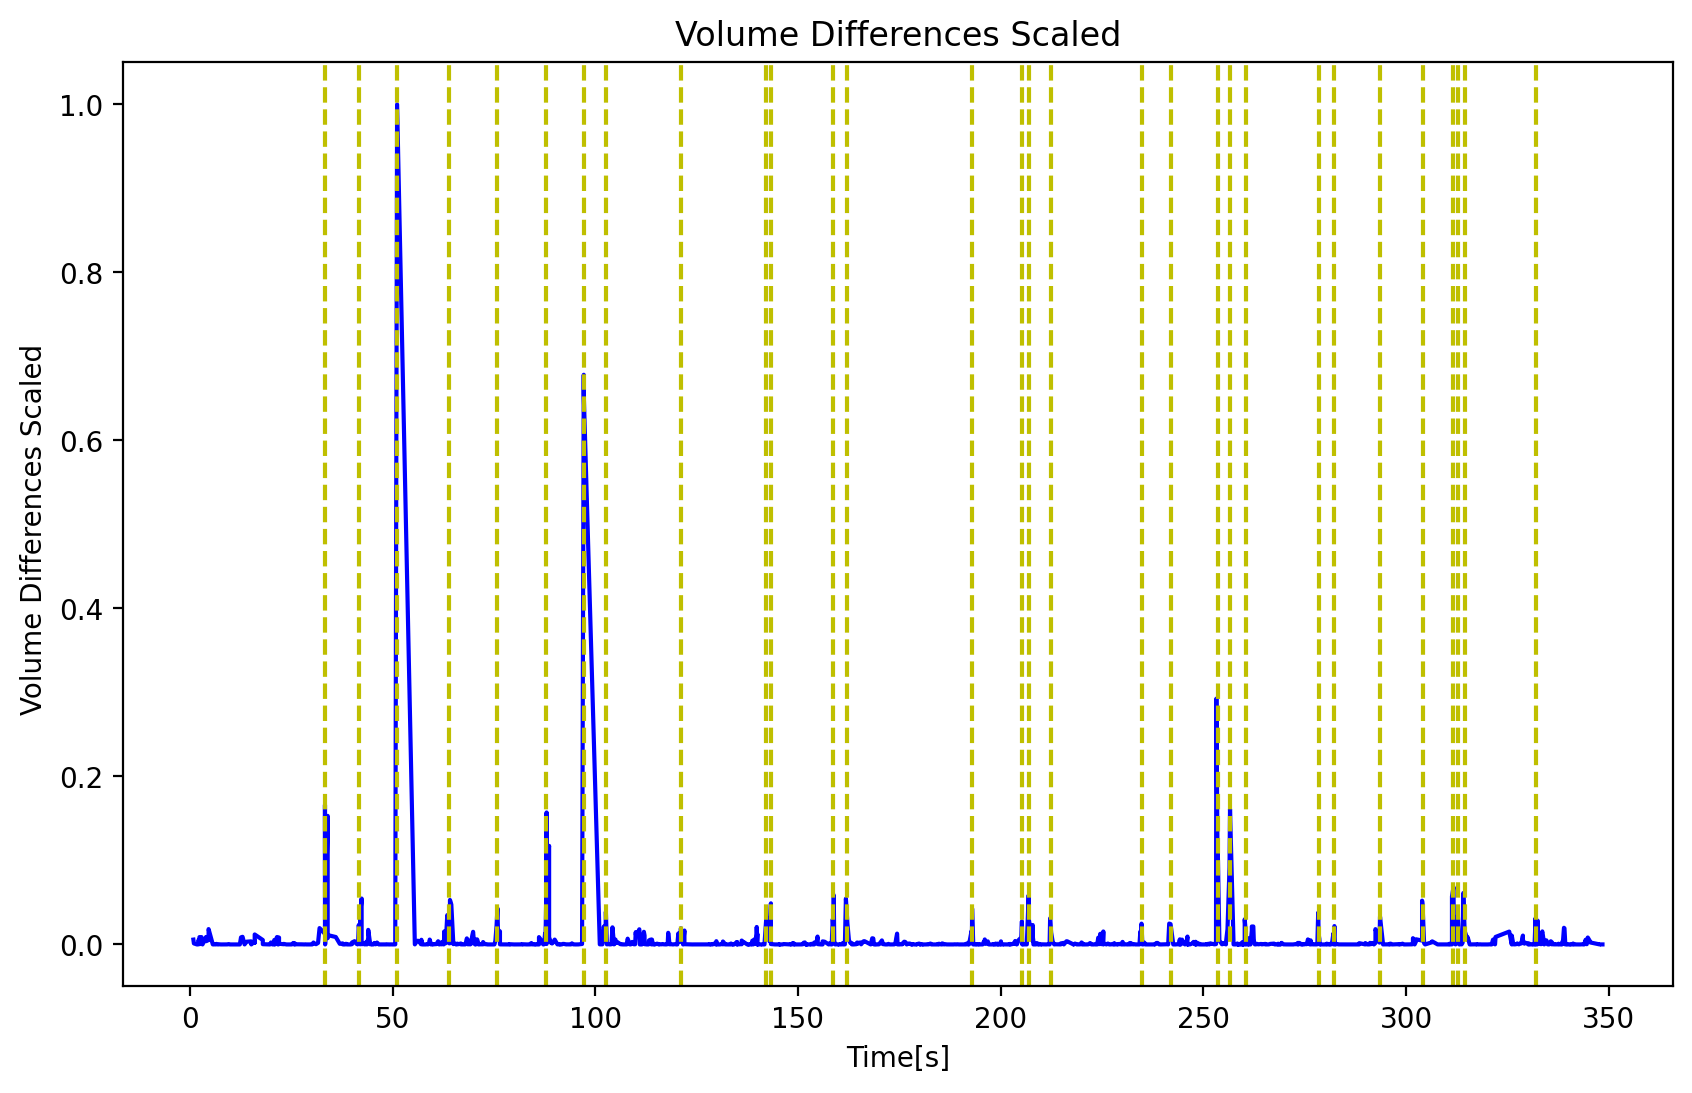

In [87]:
def plot_volume_and_possibilities(list_volume_performed, filtered_data, list_time):
    list_time_second = [offset_to_seconds(x, tempo) for x in list_time]
    list_filtered_second = [offset_to_seconds(x, tempo) for x in filtered_data]
    list_volume_differences_scaled = get_scaled_differences_in_volumes(list_volume_performed)
    plt.figure(figsize=(10, 6))
    plt.plot(list_time_second[:-2], list_volume_differences_scaled, linestyle='-', color='b')
    for x in list_filtered_second:
        plt.axvline(x=x, color='y', linestyle='--')
    plt.xlabel('Time[s]')
    plt.ylabel('Volume Differences Scaled ')
    plt.title('Volume Differences Scaled')
    plt.show()

plot_volume_and_possibilities(list_volume_differences_scaled, filtered_data, list_time)

### Task C3

### Task C4